# 분석방향
- 해시태그 분리 -> 조회수와 해시태그 상위 값 분석

# 신문과방송 현황

- 신문과방송은 무엇인가?

    - 발행중인 채널?: 공식 블로그 및 뉴스레터 채널, 기사 전문과 전자책)

[언론진흥재단 - 데이콘
](https://dacon.io/competitions/official/236606/data)


# 메타데이터

---


**1. article_metrics_monthly**.xlsx

- article_id: 기사 고유 식별자(ID)  
- period: 집계 기준 기간((YYYY-MM 형식, 월 단위)  
- comments: 해당 월 동안 기사에 달린 댓글 수  
- likes: 해당 월 동안 기사에 기록된 공감 수  
- views_total: 해당 월 동안 기사 조회수


---


**2. contents**.xlsx

- post_id-> article_id: 게시물 고유 식별자(ID)  
- category: 게시물이 속한 카테고리(예: 커버스토리, - 취재기·제작기)  
- title: 게시물 제목  
- content: 게시물 본문 텍스트  
- date: 게시물 작성일자
- tag: 게시물 태그 키워드
- source_url: 게시물 원문 URL  



---


**3~4. demographics_part001**.xlsx, demographics_part002.xlsx

- article_id: 기사 고유 식별자(ID)  
- period: 집계 기준 기간(YYYY-MM 형식, 월 단위)  
- age_group: 연령대(예: 10대, 20대, 30대 등)  
- gender: 성별(남, 여)  
- views: 해당 연령/성별 그룹에서의 조회수  
- ratio: 전체 조회수 대비 특정 연령/성별 그룹이 차지하는 비율(%)


---

**5. referrer**.xlsx

- article_id: 기사 고유 식별자(ID)  
- article_title: 기사 제목  
- period: 집계 기준 기간(YYYY-MM 형식, 월 단위)  
- referrer: 유입 경로 대분류(예: 네이버 블로그_PC, 네이버 블로그_모바일 등)  
- referrer_detail: 세부 유입 경로(예: 검색어, 유입 링크 등)  
- share: 해당 유입경로를 통한 조회수 비율(%)  


# 1. 라이브러리 및 기초설정

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys

# Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
    # debconf를 Noninteractive 모드로 설정
    !echo 'debconf debconf/frontend select Noninteractive' | \
    debconf-set-selections

    # fonts-nanum 패키지를 설치
    !sudo apt-get -qq -y install fonts-nanum

    # Matplotlib의 폰트 매니저 가져오기
    import matplotlib.font_manager as fm

    # 나눔 폰트의 시스템 경로 찾기
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

    # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'NanumGothic'    #사용 방법1
plt.rc('font', family='NanumBarunGothic', size=11) #사용 방법2
print(plt.rcParams['font.family'], plt.rcParams['font.size'])   # 폰트확인



['NanumBarunGothic'] 11.0


# [1] 데이터 불러오기

In [2]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

PATH = "/content/drive/MyDrive/언론진흥재단-데이터/analysis"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import random
import numpy as np
import os

# 1. Python 기본 random 시드
random.seed(42)

# 2. Numpy 시드
np.random.seed(42)

# 3. PYTHONHASHSEED 환경변수 (해시 기반 랜덤성 제거)
os.environ['PYTHONHASHSEED'] = '42'

In [4]:
"""

article_metrics_monthly.xlsx
contents.xlsx
demographics_part001.xlsx
demographics_part002.xlsx
referrer.xlsx

"""

article_metrics_monthly = pd.read_excel("/content/drive/MyDrive/언론진흥재단-데이터/analysis/article_metrics_monthly.xlsx")
contents = pd.read_excel("/content/drive/MyDrive/언론진흥재단-데이터/analysis/contents.xlsx")
demographics_part001 = pd.read_excel("/content/drive/MyDrive/언론진흥재단-데이터/analysis/demographics_part001.xlsx")
demographics_part002 = pd.read_excel("/content/drive/MyDrive/언론진흥재단-데이터/analysis/demographics_part002.xlsx")
referrer = pd.read_excel("/content/drive/MyDrive/언론진흥재단-데이터/analysis/referrer.xlsx")


# [2] 데이터 탐색

## 2.1 기초탐색(데이터타입, 결측치, 변수유형, 상위빈도)

**1. article_metrics_monthly**<br>

[변수 유형] 0 to 45343
- 'article_id', 'period', 'comments', 'likes', 'views_total'

[변수 타입 및 결측치]
- 타입: period(문자형->datetime 변환필요) 제외 Int, float(수치형))
- 결측치 : comments -> 45318/45344 유일하게 결측치 26개 有

In [7]:
# article_metrics_monthly 데이터 탐색(base)
print(article_metrics_monthly.columns)
print(article_metrics_monthly.info())

Index(['article_id', 'period', 'comments', 'likes', 'views_total'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45344 entries, 0 to 45343
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   article_id   45344 non-null  int64  
 1   period       45344 non-null  object 
 2   comments     45318 non-null  float64
 3   likes        45344 non-null  int64  
 4   views_total  45344 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ MB
None


**2. contents** <br>

[변수 유형] 0 to 1745
- 'article_id', 'category', 'title', 'content', 'date', 'tag', 'source_url'

[변수 타입 및 결측치]
- 타입: article_id(int) 제외 모두 문자형(object)
- 결측치 : category(1745/1746), content(1745/1746), date(1745/1746),tag(1322/1746)

In [8]:
# contents 데이터 탐색(base)
print(contents.columns)
print(contents.info())

Index(['article_id', 'category', 'title', 'content', 'date', 'tag',
       'source_url'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1746 entries, 0 to 1745
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  1746 non-null   int64 
 1   category    1745 non-null   object
 2   title       1746 non-null   object
 3   content     1745 non-null   object
 4   date        1745 non-null   object
 5   tag         1322 non-null   object
 6   source_url  1746 non-null   object
dtypes: int64(1), object(6)
memory usage: 95.6+ KB
None


**3. demographics_part001** <br>

[변수 유형] 0 to 999999
- 'article_id', 'period', 'age_group', 'gender', 'views', 'ratio'

[변수 타입 및 결측치]
- 타입: article_id, views, ratio(수치형) 제외 모두 문자형(preiod, age_group, gender
- 결측치 : X

In [9]:
# demographics_part001 데이터 탐색(base)
print(demographics_part001.columns)
print(demographics_part001.info())

Index(['article_id', 'period', 'age_group', 'gender', 'views', 'ratio'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   article_id  1000000 non-null  int64  
 1   period      1000000 non-null  object 
 2   age_group   1000000 non-null  object 
 3   gender      1000000 non-null  object 
 4   views       1000000 non-null  int64  
 5   ratio       1000000 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 45.8+ MB
None


**4. demographics_part002** <br>

[변수 유형] 0 to 89503
- 'article_id', 'period', 'age_group', 'gender', 'views', 'ratio'

[변수 타입 및 결측치]
- 타입: article_id, views, ratio(수치형) 제외 모두 문자형(preiod, age_group, gender)
- 결측치 : X

In [10]:
# demographics_part002 데이터 탐색(base)
print(demographics_part002.columns)
print(demographics_part002.info())# demographics_part002 데이터 탐색(base)

Index(['article_id', 'period', 'age_group', 'gender', 'views', 'ratio'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89504 entries, 0 to 89503
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   article_id  89504 non-null  int64  
 1   period      89504 non-null  object 
 2   age_group   89504 non-null  object 
 3   gender      89504 non-null  object 
 4   views       89504 non-null  int64  
 5   ratio       89504 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 4.1+ MB
None


**5. referrer** <br>

[변수 유형] 0 to 194946
- 'article_id', 'article_title', 'period', 'referrer', 'referrer_detail','share'

[변수 타입 및 결측치]
- 타입: article_id, share -> 숫자형
- 결측치 : X

In [11]:
# referrer 데이터 탐색(base)
print(referrer.columns)
print(referrer.info())

Index(['article_id', 'article_title', 'period', 'referrer', 'referrer_detail',
       'share'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194947 entries, 0 to 194946
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   article_id       194947 non-null  int64  
 1   article_title    194947 non-null  object 
 2   period           194947 non-null  object 
 3   referrer         194947 non-null  object 
 4   referrer_detail  194947 non-null  object 
 5   share            194947 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 8.9+ MB
None


## 2.2 데이터 값 빈도 분석

### 2.2.1 article_metrics_monthly

In [10]:
article_metrics_monthly

,article_id,period,comments,likes,views_total
0,221763439722,2023-07,0.0,0,3
1,221763439722,2023-08,0.0,0,8
2,221763439722,2023-09,0.0,0,5
3,221763439722,2023-10,0.0,0,5
4,221763439722,2023-11,0.0,0,11
...,...,...,...,...,...
45339,223950126354,2025-04,0.0,0,0
45340,223950126354,2025-05,0.0,0,0
45341,223950126354,2025-06,0.0,0,0
45342,223950126354,2025-07,3.0,5,51


In [12]:
article_metrics_monthly.comments.value_counts().head(30)

# commetns -> 0개수 다수, 1,2,3,4개 등 comments 는 값이 매우 저조 -> 분석에 유의미한 영향을 주지 못할 것이라 판단

,count
comments,
0.0,44884
1.0,273
2.0,82
3.0,47
4.0,13
6.0,5
7.0,5
5.0,3
8.0,3


In [13]:
article_metrics_monthly.likes.value_counts().head(30)

# likes -> 0개수 다수, -> 분석에 용이x

,count
likes,
0,44046
1,698
2,110
5,80
4,76
6,61
3,60
8,51
7,40


In [5]:
# article_metrics_monthly.views_total.value_counts().head(100)
views_total_30up = article_metrics_monthly[article_metrics_monthly["views_total"] >= 30] # views_total >= 30 -> 3114개
views_total_20up = article_metrics_monthly[article_metrics_monthly["views_total"] >= 20] # views_total >= 20 -> 4871개
views_total_10up = article_metrics_monthly[article_metrics_monthly["views_total"] >= 10] # views_total >= 10 -> 9428개
# -> views_total 이 30 이상인 값 우선 분석 (3114개 대상)


### 2.2.2 contents

In [15]:
contents.tag.value_counts()
# 태그 분류 -> 태그별 조회수 -> 연령대 등

,count
tag,
"#여행기자,#여행,#기자,#언론,#해외여행,#전문성,#비즈니스",1
"#언론,#신문과방송,#신문기자,#방송기자,#기자,#기레기,#기사,#이슈,#신뢰도,#신뢰쌓기,#기사쓰기,#글쓰기",1
"#신문과방송,#한국언론진흥재단,#언론인,#설문조사,#기자,#기자되는법,#만족도,#기자생활,#평기자,#디지털,#주52시간,#한국언론,#언론자유도",1
"#대한민국,#키워드,#2020,#새해,#경제,#남북관계,#대통령,#새해소망,#한국언론진흥원",1
"#신문과방송,#한국언론진흥재단,#언론,#언론인,#기자,#신문,#종이신문,#구독자,#신문사",1
...,...
"#신문과방송,#한국언론진흥재단,#신문,#방송,#신문기자,#방송기자,#신문사,#방송국,#북리뷰,#특종의탄생,#기자,#기사쓰기",1
"#신문과방송,#한국언론진흥재단,#기자,#방송국,#신문사,#신문,#방송,#출입처,#폐지,#KBS,#심층취재",1
"#신문과방송,#한국언론진흥재단,#한국,#언론,#신문,#방송,#신문사,#방송사,#EBS,#다큐멘터리,#다큐,#다큐프라임,#진정성",1


In [16]:
contents.category.value_counts()

# 카테고리별 조회수
# 카테고리별 인기 조회수 상위?
# contents + demographics + montly_article_metrics => merge =>
# 카테고리별 조회수(성별/연령대별) + referrer(referrer, share)

,count
category,
커버스토리,254
취재기·제작기,205
미디어 월드 와이드,203
집중점검,152
미디어현장,142
기획연재,133
미디어포럼,123
카드뉴스,117
미디어·AI트렌드,58


### 2.2.3~4 demographics

In [17]:
# 연령별로 값이 골고루 분포했는지? -> o
print(demographics_part001.age_group.value_counts())
# 성별별로 값이 골고루 분포했는지? -> o
print(demographics_part001.gender.value_counts())

age_group
전체       83334
0-12     83334
13-18    83334
19-24    83334
25-29    83334
30-34    83334
35-39    83334
40-44    83334
45-49    83332
50-54    83332
55-59    83332
60-      83332
Name: count, dtype: int64
gender
남    500000
여    500000
Name: count, dtype: int64


In [18]:
demographics_part001.views.value_counts()

# 0~30 값이 상위 30 -> 30이상부터 조회수 체크


,count
views,
0,914423
1,36500
2,15693
3,8881
4,5863
...,...
148,1
176,1
116,1


In [6]:
views_30up = demographics_part001[demographics_part001["views"] >= 30]

views_30up[views_30up["article_id"]== 221787926889]

# ratio 변수: 전체 조회수 대비 특정 연령 / 성별 그룹이 차지하는 비율
# -> ratio 활용 연령대별, 성별 비율 체크

,article_id,period,age_group,gender,views,ratio
7393,221787926889,2025-05,전체,여,40,100.0
7401,221787926889,2025-05,25-29,여,38,95.0


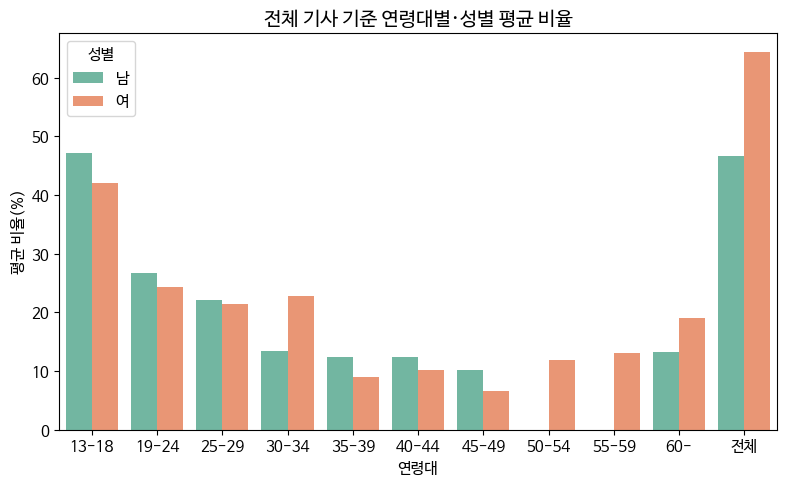

In [20]:
# ratio_summary = 조회수 값이 30 이상 -> 간행물별, 연령대별, 성별 -> 비율
# mean 집계
# ratio_mean = 조회수 값이 30 이상 -> 연령대, 성별 -> 비율
import seaborn as sns

ratio_summary = (
    views_30up.groupby(["article_id", "age_group", "gender"])["ratio"]
    .mean()
    .reset_index()
)

ratio_mean = (
    views_30up.groupby(["age_group", "gender"])["ratio"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=ratio_mean,
    x="age_group",
    y="ratio",
    hue="gender",
    palette="Set2"
)
plt.title("전체 기사 기준 연령대별·성별 평균 비율", fontsize=14)
plt.xlabel("연령대")
plt.ylabel("평균 비율(%)")
plt.legend(title="성별")
plt.tight_layout()
plt.show()

# 1. 13~18 = 남성 비율 약간 우세 -> 첫번째로 조회수 비율 높음
# 2. 13~18, 19~24, 25~29 비중이 top3
# 3. 30~34, 35~39, 40~44,45~49, 50~54, 55~59, 60~ 비중이 하위 그룹(값은 각 그룹별로 비슷함)

# => 간행물 주 소비층 = 13~18
# => 50~54, 55~59 연령대의 남성 값이 없음?


In [21]:
views_30up[views_30up["age_group"] == "55-59"]
# views_30up[viewsㅠ_30up["age_group"] == "13-18"] # -> 값 o

# ?

,article_id,period,age_group,gender,views,ratio
759117,223129734365,2024-08,55-59,여,37,12.09
759141,223129734365,2024-09,55-59,여,71,13.92


### 2.2.5 referrer

In [22]:

"""
[referrer_detail]
1. 눈에띄는 referrer: chatgpt, stibee,wrtn
2. ai에 걸리는 간행물의 수가 얼마나 되나?

"""

referrer["referrer_detail"].value_counts().head(50)


,count
referrer_detail,
https://www.google.com,13955
https://www.google.co.kr,4481
https://www.bing.com,1148
https://search.naver.com,715
신문과 방송,709
https://m.blog.naver.com/PostList.naver?blogId=kpfjra_&tab=1,615
신문과방송,611
https://www.naver.com/my.html,590
https://chatgpt.com,588


In [23]:

pd.set_option('display.max_rows', 200)  # 100보다 여유 있게 설정
print(referrer["referrer"].value_counts().head(100))
# 1. 눈에띄는 것: 네이버 통합검색(모바일과 pc 분류), 네이버 블로그(pc, 모바일), 네이버블로그검색(모바일,pc), 네이버 뷰검색(모바일,PC)
# google, bing, 네이버 메인(pc, 모바일), 다음 검색(모바일,pc), 네이버검색(기타), 네이버 이미지검색(pc),
# 2. ai' referrer 상위 순서: chatgpt(581), perplexity.ai(563), wrtn(101))
# 3. 뉴스레터 사이트 상위 순서: Stibee
# 4. www.semyung.ac.kr -> 세명대학교, cyber.inu.ac.kr -> 인천대학교 걸릴만한 곳이 어디?
# 5. 나무위키
# 6. kpfwi -> 진흥재단? ,한반도미래여성연구소
# 7. 야후, zum
# 8. hiworks(51)

###

# sum
# 1. 포털사이트별 구분(네이버, 다음)
# 2. 포털사이트의 유형별 구분(블로그, 검색, 이미지 검색, 뷰검색, 메인, 카페 등)
# 3. pc, 모바일 별 분류
# 4. 콘텐츠 유형별 분류(블로그, 카페, 뉴스레터, 메일, 위키 등)
# 5. 기타 분류 - 대학교(세명대학교, 인천대학교)
# 6. 생성형 AI 분류 (지피티, 퍼플, 뤼튼)

referrer
네이버 통합검색_모바일                               59633
네이버 통합검색_PC                                52593
네이버 블로그_PC                                 24033
Google                                     20090
네이버 블로그_모바일                                 9277
네이버 블로그검색_모바일                               3820
네이버 뷰검색_모바일                                 3366
네이버 블로그검색_PC                                3277
기타                                          2756
네이버 뷰검색_PC                                  2701
Bing                                        1190
네이버 메인_PC                                    942
Daum 검색_모바일                                  693
네이버 검색_기타                                    691
네이버 이미지검색_PC                                 609
Daum 검색_PC                                   583
chatgpt.com                                  581
www.perplexity.ai                            563
다음 검색_모바일                                    494
네이버 이미지검색_모바일                                492
네이버 웹문서검색_모

**referrer -> share**
- 공유 수 상위 아티클
    - 10up = 66288/194947
    - 30up = 27150/194947

In [24]:
# 공유 수 상위 아티클?
referrer["share"].value_counts().head(50)

# share 10개 이상 (66288/194947)
# share 30개 이상 (27150/194947)

share_10up = referrer[referrer["share"] >= 10]
share_30up = referrer[referrer["share"] >= 30]


### 2.2 sum
[article_metrics_monthly]

- commetns -> 0개수 다수, 1,2,3,4개 등 comments 는 값이 매우 저조 -> 분석에 유의미한 영향을 주지 못할 것이라 판단
- likes -> 0개수 다수, 1,2,3,4개 등 likes 는 값이 매우 저조 -> 분석에 유의미한 영향을 주지 못할 것이라 판단(comments 보다는 값 높음)

- views_total_30up = article_metrics_monthly[article_metrics_monthly["views_total"] >= 30] # views_total >= 30 -> 3114개
- views_total_20up = article_metrics_monthly[article_metrics_monthly["views_total"] >= 20] # views_total >= 20 -> 4871개
- views_total_10up = article_metrics_monthly[article_metrics_monthly["views_total"] >= 10] # views_total >= 10 -> 9428개
- views_total 이 30 이상인 값 우선 분석 (3114개 대상)
---

[contents]

- 태그 분류 -> 태그별 조회수 -> 연령대 등
- 카테고리별 조회수
- 카테고리별 인기 조회수 상위?
- contents + demographics + montly_article_metrics => merge =>
- 카테고리별 조회수(성별/연령대별) + referrer(referrer, share)

----

[demo]
- 1. 13-18 = 남성 비율 약간 우세 -> 첫번째로 조회수 비율 높음
- 2. 13-18, 19-24, 25-29 비중이 top3
- 3. 30-34, 35-39, 40-44,45-49, 50-54, 55-59, 60~ 비중이 하위 그룹(값은 각 그룹별로 비슷함)

=> 간행물 주 소비층 = 13~18

-----

[referrer]
- 1. 눈에띄는 것: 네이버 통합검색(모바일과 pc 분류), 네이버 블로그(pc, 모바일), 네이버블로그검색(모바일,pc), 네이버 뷰검색(모바일,PC)
- google, bing, 네이버 메인(pc, 모바일), 다음 검색(모바일,pc), 네이버검색(기타), 네이버 이미지검색(pc),
- 2. ai' referrer 상위 순서: chatgpt(581), perplexity.ai(563), wrtn(101))
- 3. 뉴스레터 사이트 상위 순서: Stibee
- 4. www.semyung.ac.kr -> 세명대학교, cyber.inu.ac.kr -> 인천대학교 걸릴만한 곳이 어디?
- 5. 나무위키
- 6. kpfwi -> 진흥재단? ,한반도미래여성연구소
- 7. 야후, zum
- 8. hiworks(51)

-----

###

# sum
- 1. 포털사이트별 구분(네이버, 다음)
- 2. 포털사이트의 유형별 구분(블로그, 검색, 이미지 검색, 뷰검색, 메인, 카페 등)
- 3. pc, 모바일 별 분류
- 4. 콘텐츠 유형별 분류(블로그, 카페, 뉴스레터, 메일, 위키 등)
- 5. 기타 분류 - 대학교(세명대학교, 인천대학교)
- 6. 생성형 AI 분류 (지피티, 퍼플, 뤼튼)

# 데이터 분포
[article_metrics_monthly]
- comments, likews: 0값 대다수 +  1,2,3,4값 다수 그 이상의 값은 미존재
- 분석 시 유의미한 영향을 주지 못할 것이라고 판단
- views_total: 값이 comments, likes에 비해 골고루 분포
- views_total' 10up = 9428개, '20up = 4871개, '30up = 3114개 존재
- article_metrics_monthly 데이터셋의 views_total 값이 30 이상인 데이터만 선별

[contents]
- 태그: 태그분류 필요(#기준) -> 태그별 조회수 추이
- 카테고리: 카테고리 분류 -> 카테고리별 조회수
- 카테고리별 성별/연령대별 분포 + 조회수 + referrer 유형 파악

[demographics]
- 연령대별: 13-18 연령대 top1 -> 남성 비율 약간 우세하나 큰 차이 아님
- 13-29 연령대 그룹의 비중이 top3
- 30-60~ 연령대 그룹은 하위권 그룹으로 값이 유사
- article 주 소비층 = 13-18 연령대(article 톤앤매너는 old하기 때문에 청년층보다 노년층이 많이 볼 것이다? -> X)
- demographics1 + demographics2 적재필요

[referrer]
- referrer:
    - 포털사이트별(네이버, 다음)
    - 포털사이트의 유형별(블로그, 검색, 이미지 검색, 뷰검색, 메인, 카페 등)
    - pc, 모바일 별
    - 콘텐츠 유형별(블로그, 카페, 뉴스레터, 메일, 위키 등)
    - 기타(대학교 - 세명대학교, 인천대학교)
    - 생성형 AI(상위 3 - 챗gpt - 퍼플렉시티 - 뤼튼)

# [3] 데이터 통합

## 3.1 결측치 처리

In [25]:
# 결측치 처리 전

print("Missing values in article_metrics_monthly:")
print(article_metrics_monthly.isnull().sum())

print("\nMissing values in contents:")
print(contents.isnull().sum())

print("\nMissing values in demographics_part001:")
print(demographics_part001.isnull().sum())

print("\nMissing values in demographics_part002:")
print(demographics_part002.isnull().sum())

print("\nMissing values in referrer:")
print(referrer.isnull().sum())

Missing values in article_metrics_monthly:
article_id      0
period          0
comments       26
likes           0
views_total     0
dtype: int64

Missing values in contents:
article_id      0
category        1
title           0
content         1
date            1
tag           424
source_url      0
dtype: int64

Missing values in demographics_part001:
article_id    0
period        0
age_group     0
gender        0
views         0
ratio         0
dtype: int64

Missing values in demographics_part002:
article_id    0
period        0
age_group     0
gender        0
views         0
ratio         0
dtype: int64

Missing values in referrer:
article_id         0
article_title      0
period             0
referrer           0
referrer_detail    0
share              0
dtype: int64


In [7]:
# contents의 tag 변수의 결측치는 "미기재"로 처리(작성 시 태그처리를 안한것으로 가정)
contents['tag'].fillna('미기재', inplace=True)
print(contents.isnull().sum())

# contents의 category 변수의 결측치 1개는 최빈값으로 처리
contents['category'].fillna(contents['category'].mode()[0], inplace=True)
print(contents.isnull().sum())

# Drop the row with missing 'content' and 'date' in contents
contents.dropna(subset=['content', 'date'], inplace=True)

# Impute missing 'comments' with 0 in article_metrics_monthly
article_metrics_monthly['comments'].fillna(0, inplace=True)

# Verify missing values are handled
print("Missing values in contents after handling:")
print(contents.isnull().sum())

print("\nMissing values in article_metrics_monthly after handling:")
print(article_metrics_monthly.isnull().sum())

article_id    0
category      1
title         0
content       1
date          1
tag           0
source_url    0
dtype: int64
article_id    0
category      0
title         0
content       1
date          1
tag           0
source_url    0
dtype: int64
Missing values in contents after handling:
article_id    0
category      0
title         0
content       0
date          0
tag           0
source_url    0
dtype: int64

Missing values in article_metrics_monthly after handling:
article_id     0
period         0
comments       0
likes          0
views_total    0
dtype: int64


In [27]:
# 결측치 처리 완료

print("Missing values in article_metrics_monthly:")
print(article_metrics_monthly.isnull().sum())

print("\nMissing values in contents:")
print(contents.isnull().sum())

print("\nMissing values in demographics_part001:")
print(demographics_part001.isnull().sum())

print("\nMissing values in demographics_part002:")
print(demographics_part002.isnull().sum())

print("\nMissing values in referrer:")
print(referrer.isnull().sum())

Missing values in article_metrics_monthly:
article_id     0
period         0
comments       0
likes          0
views_total    0
dtype: int64

Missing values in contents:
article_id    0
category      0
title         0
content       0
date          0
tag           0
source_url    0
dtype: int64

Missing values in demographics_part001:
article_id    0
period        0
age_group     0
gender        0
views         0
ratio         0
dtype: int64

Missing values in demographics_part002:
article_id    0
period        0
age_group     0
gender        0
views         0
ratio         0
dtype: int64

Missing values in referrer:
article_id         0
article_title      0
period             0
referrer           0
referrer_detail    0
share              0
dtype: int64


## 3.2 데이터셋 처리(일정값 이상 데이터만 선별)

In [8]:
views_total_30up = article_metrics_monthly[article_metrics_monthly["views_total"] >= 30] # views_total >= 30 -> 3114개
views_total_30up

,article_id,period,comments,likes,views_total
160,221773238496,2023-11,0.0,0,51
182,221773270282,2023-07,0.0,0,57
183,221773270282,2023-08,0.0,0,44
184,221773270282,2023-09,0.0,0,45
185,221773270282,2023-10,0.0,0,71
...,...,...,...,...,...
45291,223950117496,2025-08,0.0,1,267
45316,223950119662,2025-07,0.0,3,77
45317,223950119662,2025-08,0.0,8,73
45342,223950126354,2025-07,3.0,5,51


### 3.2.1 demographics 데이터셋 병합
- demographics_combined

In [9]:
print(len(demographics_part001))
print(len(demographics_part002))
# Combine demographics_part001 and demographics_part002
demographics_combined = pd.concat([demographics_part001, demographics_part002], ignore_index=True)

print("Combined demographics dataframe shape:", demographics_combined.shape)
display(demographics_combined.head())
display(demographics_combined.tail())

1000000
89504
Combined demographics dataframe shape: (1089504, 6)


,article_id,period,age_group,gender,views,ratio
0,221763439722,2023-07,전체,남,0,0.0
1,221763439722,2023-07,전체,여,0,0.0
2,221763439722,2023-07,0-12,남,0,0.0
3,221763439722,2023-07,0-12,여,0,0.0
4,221763439722,2023-07,13-18,남,0,0.0


,article_id,period,age_group,gender,views,ratio
1089499,223950126354,2025-08,50-54,여,2,1.89
1089500,223950126354,2025-08,55-59,남,4,3.77
1089501,223950126354,2025-08,55-59,여,0,0.00
1089502,223950126354,2025-08,60-,남,5,4.72
1089503,223950126354,2025-08,60-,여,1,0.94


## 3.3 데이터 타입 변환(분석 가능한 수치형으로)

In [10]:
# Convert 'period' column to datetime in article_metrics_monthly
article_metrics_monthly['period'] = pd.to_datetime(article_metrics_monthly['period'])

# Convert 'period' column to datetime in demographics_combined
demographics_combined['period'] = pd.to_datetime(demographics_combined['period'])

# Convert 'period' column to datetime in referrer
referrer['period'] = pd.to_datetime(referrer['period'])

# Convert 'date' column to datetime in contents
contents['date'] = pd.to_datetime(contents['date'])

print("Data types after conversion:")
print("\narticle_metrics_monthly:")
print(article_metrics_monthly.info())
print("\ndemographics_combined:")
print(demographics_combined.info())
print("\nreferrer:")
print(referrer.info())
print("\ncontents:")
print(contents.info())

Data types after conversion:

article_metrics_monthly:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45344 entries, 0 to 45343
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   article_id   45344 non-null  int64         
 1   period       45344 non-null  datetime64[ns]
 2   comments     45344 non-null  float64       
 3   likes        45344 non-null  int64         
 4   views_total  45344 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 1.7 MB
None

demographics_combined:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089504 entries, 0 to 1089503
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   article_id  1089504 non-null  int64         
 1   period      1089504 non-null  datetime64[ns]
 2   age_group   1089504 non-null  object        
 3   gender      1089504 non-null 

## 3.4 데이터 병합

- views_total_30up (article_metrics_monthly)
- contents
- demographics_combined (demographics 001~002)
- referrer

# [4] 병합데이터 불러오기

In [94]:
import pandas as pd

ver1_dataset = pd.read_csv("/content/drive/MyDrive/언론진흥재단-데이터/analysis/ver1_dataset.csv")
ver1_dataset.head()

,period,age_group_10,gender,views,ratio,views_total,category,title,tag,source_url,referrer,referrer_detail,share
0,2024-07-01,10대 이하,여,1,14.29,12,커버스토리,언론과 독자 : 기자에게 언론 신뢰를 묻다…기자 87% “내 기사 신뢰해”… 언론 믿는 수용자는 28%뿐,"#언론,#신문과방송,#신문기자,#방송기자,#기자,#기레기,#기사,#이슈,#신뢰도,#신뢰쌓기,#기사쓰기,#글쓰기",https://blog.naver.com/kpfjra_/221763439722,Google,https://www.google.com,55.56
1,2024-07-01,10대 이하,여,1,14.29,12,커버스토리,언론과 독자 : 기자에게 언론 신뢰를 묻다…기자 87% “내 기사 신뢰해”… 언론 믿는 수용자는 28%뿐,"#언론,#신문과방송,#신문기자,#방송기자,#기자,#기레기,#기사,#이슈,#신뢰도,#신뢰쌓기,#기사쓰기,#글쓰기",https://blog.naver.com/kpfjra_/221763439722,Google,https://www.google.co.kr,11.11
2,2024-07-01,10대 이하,여,1,14.29,12,커버스토리,언론과 독자 : 기자에게 언론 신뢰를 묻다…기자 87% “내 기사 신뢰해”… 언론 믿는 수용자는 28%뿐,"#언론,#신문과방송,#신문기자,#방송기자,#기자,#기레기,#기사,#이슈,#신뢰도,#신뢰쌓기,#기사쓰기,#글쓰기",https://blog.naver.com/kpfjra_/221763439722,네이버 통합검색_모바일,기레기 언론 신뢰,11.11
3,2024-07-01,10대 이하,여,1,14.29,12,커버스토리,언론과 독자 : 기자에게 언론 신뢰를 묻다…기자 87% “내 기사 신뢰해”… 언론 믿는 수용자는 28%뿐,"#언론,#신문과방송,#신문기자,#방송기자,#기자,#기레기,#기사,#이슈,#신뢰도,#신뢰쌓기,#기사쓰기,#글쓰기",https://blog.naver.com/kpfjra_/221763439722,네이버 통합검색_모바일,기자에게할만한질문,11.11
4,2024-07-01,10대 이하,여,1,14.29,12,커버스토리,언론과 독자 : 기자에게 언론 신뢰를 묻다…기자 87% “내 기사 신뢰해”… 언론 믿는 수용자는 28%뿐,"#언론,#신문과방송,#신문기자,#방송기자,#기자,#기레기,#기사,#이슈,#신뢰도,#신뢰쌓기,#기사쓰기,#글쓰기",https://blog.naver.com/kpfjra_/221763439722,네이버 이미지검색_PC,설문조사 언론기사,11.11


## 4.1 데이터 탐색(eda)

### 4.1.1 referrer 유형별 분포

In [95]:
 # 1. Referrer 유형별 분포

print("=== Referrer 유형별 분포 (상위 200개) ===")
referrer_counts = ver1_dataset['referrer'].value_counts()
print(referrer_counts.head(200))

print(f"\n총 {len(referrer_counts)}개의 고유 referrer\n")


=== Referrer 유형별 분포 (상위 200개) ===
referrer
네이버 통합검색_모바일                               380988
네이버 통합검색_PC                                329850
네이버 블로그_PC                                 144179
Google                                      60756
네이버 블로그_모바일                                 57816
기타                                          29327
네이버 블로그검색_모바일                               23564
네이버 뷰검색_모바일                                 21081
네이버 블로그검색_PC                                19362
네이버 뷰검색_PC                                  16897
네이버 메인_PC                                    9364
Bing                                         5018
Daum 검색_모바일                                  4219
네이버 검색_기타                                    3700
Daum 검색_PC                                   3231
다음 검색_모바일                                    2839
네이버 웹문서검색_모바일                                2647
link.naver.com                               2515
chatgpt.com                                  2151
stibee.

### 4.1.2 referrer 비율

In [96]:
# 2. Referrer 비율
print("=== Referrer 비율 (%) ===")
referrer_ratio = (ver1_dataset['referrer'].value_counts() / len(ver1_dataset) * 100).head(20)
print(referrer_ratio)
print()


=== Referrer 비율 (%) ===
referrer
네이버 통합검색_모바일      32.800841
네이버 통합검색_PC       28.398158
네이버 블로그_PC        12.412970
Google             5.230737
네이버 블로그_모바일        4.977620
기타                 2.524883
네이버 블로그검색_모바일      2.028723
네이버 뷰검색_모바일        1.814951
네이버 블로그검색_PC       1.666955
네이버 뷰검색_PC         1.454733
네이버 메인_PC          0.806186
Bing               0.432020
Daum 검색_모바일        0.363231
네이버 검색_기타          0.318548
Daum 검색_PC         0.278170
다음 검색_모바일          0.244421
네이버 웹문서검색_모바일      0.227891
link.naver.com     0.216527
chatgpt.com        0.185189
stibee.com         0.169605
Name: count, dtype: float64



### 4.1.3 포털별 분류

In [97]:


# 4. 포털별 분류
print("=== 포털 분류 ===")
naver = ver1_dataset[ver1_dataset['referrer'].str.contains('네이버|naver', case=False, na=False)]
google = ver1_dataset[ver1_dataset['referrer'].str.contains('google', case=False, na=False)]
daum = ver1_dataset[ver1_dataset['referrer'].str.contains('다음|daum|kakao', case=False, na=False)]
야후 = ver1_dataset[ver1_dataset['referrer'].str.contains('야후', case=False, na=False)]
Zum = ver1_dataset[ver1_dataset['referrer'].str.contains('Zum', case=False, na=False)]

print(f"네이버: {len(naver):,}개 ({len(naver)/len(ver1_dataset)*100:.1f}%)")
print(f"구글: {len(google):,}개 ({len(google)/len(ver1_dataset)*100:.1f}%)")
print(f"다음/카카오: {len(daum):,}개 ({len(daum)/len(ver1_dataset)*100:.1f}%)")
print(f"야후: {len(야후):,}개 ({len(야후)/len(ver1_dataset)*100:.1f}%)")
print(f"Zum: {len(Zum):,}개 ({len(Zum)/len(ver1_dataset)*100:.1f}%)")
print()


=== 포털 분류 ===
네이버: 1,024,166개 (88.2%)
구글: 63,320개 (5.5%)
다음/카카오: 14,463개 (1.2%)
야후: 474개 (0.0%)
Zum: 422개 (0.0%)



### 4.1.4 모바일 vs PC

In [98]:

# 5. 모바일 vs PC
print("=== 디바이스 분류 ===")
mobile = ver1_dataset[ver1_dataset['referrer'].str.contains('모바일|mobile', case=False, na=False)]
pc = ver1_dataset[ver1_dataset['referrer'].str.contains('PC|pc', case=False, na=False)]
print(f"모바일: {len(mobile):,}개 ({len(mobile)/len(ver1_dataset)*100:.1f}%)")
print(f"PC: {len(pc):,}개 ({len(pc)/len(ver1_dataset)*100:.1f}%)")
print()

=== 디바이스 분류 ===
모바일: 500,762개 (43.1%)
PC: 529,756개 (45.6%)



### 4.1.5 AI 검색 엔진

In [99]:


# 6. AI 검색 엔진
print("=== AI 검색 엔진 유입 ===")
chatgpt = ver1_dataset[ver1_dataset['referrer'].str.contains('chatgpt', case=False, na=False)]
perplexity = ver1_dataset[ver1_dataset['referrer'].str.contains('perplexity', case=False, na=False)]
wrtn = ver1_dataset[ver1_dataset['referrer'].str.contains('wrtn.ai', case=False, na=False)]
copilot = ver1_dataset[ver1_dataset['referrer'].str.contains('copilot.microsoft.com', case=False, na=False)]

print(f"ChatGPT: {len(chatgpt):,}개")
print(f"Perplexity: {len(perplexity):,}개")
print(f"wrtn: {len(wrtn):,}개")
print(f"copilot: {len(copilot):,}개")

print()


=== AI 검색 엔진 유입 ===
ChatGPT: 2,151개
Perplexity: 1,963개
wrtn: 438개
copilot: 180개



# [5] 피쳐엔지니어링

## 5.1 referrer

### 5.1.1 pc vs mobile


In [100]:
ver1_dataset['device'] = '미분류'
ver1_dataset.loc[ver1_dataset['referrer'].str.contains('모바일', na=False), 'device'] = '모바일'
ver1_dataset.loc[ver1_dataset['referrer'].str.contains('PC', na=False), 'device'] = 'PC'
ver1_dataset["device"].value_counts()


,count
device,
PC,529756
모바일,500750
미분류,131013


### 5.1.2 포털별 분류

In [46]:
# 포털 분류
ver1_dataset['portal'] = '기타'

  # 네이버
ver1_dataset.loc[ver1_dataset['referrer'].str.contains('네이버|naver|Naver', na=False), 'portal'] = '네이버'

  # 구글
ver1_dataset.loc[ver1_dataset['referrer'].str.contains('Google|google', na=False), 'portal'] = '구글'

  # 다음/카카오
ver1_dataset.loc[ver1_dataset['referrer'].str.contains('Daum|daum|다음|Kakao|kakao', na=False), 'portal'] = '다음/카카오'

  # Bing
ver1_dataset.loc[ver1_dataset['referrer'].str.contains('Bing|bing', na=False), 'portal'] = 'Bing'

  # 야후
ver1_dataset.loc[ver1_dataset['referrer'].str.contains('야후|Yahoo|yahoo', na=False), 'portal'] = '야후'

  # Zum
ver1_dataset.loc[ver1_dataset['referrer'].str.contains('Zum|zum', na=False), 'portal'] = 'Zum'

  # Nate
ver1_dataset.loc[ver1_dataset['referrer'].str.contains('Nate|nate', na=False), 'portal'] = 'Nate'

  # 결과 확인
print("=== 포털 분류 결과 ===")
print(ver1_dataset['portal'].value_counts())
print()

print("=== 포털 비율 (%) ===")
print(ver1_dataset['portal'].value_counts(normalize=True) * 100)
print()


=== 포털 분류 결과 ===
portal
네이버       1024166
구글          63320
기타          53292
다음/카카오      14463
Bing         5018
야후            551
Zum           422
Nate          287
Name: count, dtype: int64

=== 포털 비율 (%) ===
portal
네이버       88.174709
구글         5.451482
기타         4.588130
다음/카카오     1.245180
Bing       0.432020
야후         0.047438
Zum        0.036332
Nate       0.024709
Name: proportion, dtype: float64



### 5.1.3 검색 키워드 비중

In [48]:
# "검색" 키워드 포함 여부만 체크
ver1_dataset['is_search'] = ver1_dataset['referrer'].str.contains('검색', na=False)

  # 결과 확인
print("=== '검색' 키워드 포함 여부 ===")
print(ver1_dataset['is_search'].value_counts())
print()

print("=== 비율 (%) ===")
print(ver1_dataset['is_search'].value_counts(normalize=True) * 100)
print()

  # 검색 유입 referrer 목록
print("=== '검색' 키워드 포함된 Referrer ===")
search_refs = ver1_dataset[ver1_dataset['is_search'] == True]['referrer'].value_counts()
print(search_refs)
print()

print(f"검색 유입: {ver1_dataset['is_search'].sum():,}건")
print(f"비검색 유입: {(~ver1_dataset['is_search']).sum():,}건")

  # 저장
ver1_dataset.to_csv('ver1_dataset_with_search.csv', index=False)
print("\n저장 완료: ver1_dataset_with_search.csv")


=== '검색' 키워드 포함 여부 ===
is_search
True     815398
False    346121
Name: count, dtype: int64

=== 비율 (%) ===
is_search
True     70.201004
False    29.798996
Name: proportion, dtype: float64

=== '검색' 키워드 포함된 Referrer ===
referrer
네이버 통합검색_모바일     380988
네이버 통합검색_PC      329850
네이버 블로그검색_모바일     23564
네이버 뷰검색_모바일       21081
네이버 블로그검색_PC      19362
네이버 뷰검색_PC        16897
Daum 검색_모바일        4219
네이버 검색_기타          3700
Daum 검색_PC         3231
다음 검색_모바일          2839
네이버 웹문서검색_모바일      2647
네이버 이미지검색_PC       1753
다음 검색_PC           1697
네이버 이미지검색_모바일      1482
네이버 웹문서검색_PC       1163
네이버_웹문서검색_PC        605
Nate 검색_모바일         114
Nate 검색_PC          103
네이버 검색_스마트블럭         96
네이버 쇼핑검색              7
Name: count, dtype: int64

검색 유입: 815,398건
비검색 유입: 346,121건

저장 완료: ver1_dataset_with_search.csv


### 5.1.4 커뮤니티 비중

In [53]:
# 커뮤니티 여부 분류
community_keywords = [

      'dcinside', '디시',
      'clien', '클리앙',
      'fmkorea', 'fm코리아',
      'mlbpark', '엠엘비파크',
      'ppomppu', '뽐뿌',
      'bobaedream', '보배드림',
      'instiz', '인스티즈',
      'theqoo', '더쿠',
      'ruliweb', '루리웹',
      'humoruniv', 'todayhumor',
      'dogdrip', 'dvdprime', 'slrclub'
  ]

  # 커뮤니티 체크
ver1_dataset['is_community'] = ver1_dataset['referrer'].str.contains('|'.join(community_keywords), case=False, na=False)

  # 결과 확인
print("=== 커뮤니티 유입 분석 ===")
print(ver1_dataset['is_community'].value_counts())
print(f"\n비율: {ver1_dataset['is_community'].sum() / len(ver1_dataset) * 100:.2f}%")
print()

print("=== 커뮤니티 사이트별 유입 ===")
community_data = ver1_dataset[ver1_dataset['is_community'] == True]
print(community_data['referrer'].value_counts())
print()

=== 커뮤니티 유입 분석 ===
is_community
False    1161031
True         488
Name: count, dtype: int64

비율: 0.04%

=== 커뮤니티 사이트별 유입 ===
referrer
m.dcinside.com       219
gall.dcinside.com    155
www.clien.net         38
m.clien.net           28
m.fmkorea.com         25
www.fmkorea.com       23
Name: count, dtype: int64



### 5.1.5 교육기관 비중

In [54]:
# 교육기관 (.ac.kr) 분류
ver1_dataset['is_edu'] = ver1_dataset['referrer'].str.contains('.ac.kr', na=False)

  # 결과 확인
print("=== 교육기관 유입 분석 ===")
print(ver1_dataset['is_edu'].value_counts())
print(f"\n비율: {ver1_dataset['is_edu'].sum() / len(ver1_dataset) * 100:.2f}%")
print()

  # 교육기관별 상세
print("=== 교육기관별 유입 ===")
edu_data = ver1_dataset[ver1_dataset['is_edu'] == True]
print(edu_data['referrer'].value_counts())
print()

print(f"총 교육기관 수: {edu_data['referrer'].nunique()}개")

=== 교육기관 유입 분석 ===
is_edu
False    1158423
True        3096
Name: count, dtype: int64

비율: 0.27%

=== 교육기관별 유입 ===
referrer
www.semyung.ac.kr            1657
cyber.inu.ac.kr               521
journalism.semyung.ac.kr      324
cyber.ewha.ac.kr              102
ipsi.semyung.ac.kr             63
gw.hallym.ac.kr                45
myetl.snu.ac.kr                38
mail.sogang.ac.kr              33
smics.semyung.ac.kr            30
cmail.changwon.ac.kr           23
webmail.tu.ac.kr               19
mail.cju.ac.kr                 18
learn.inha.ac.kr               16
mail.korea.ac.kr               14
ecampus.smu.ac.kr              14
semyung.ac.kr                  14
mail.cu.ac.kr                  12
sel.jnu.ac.kr                  11
ecampus.konkuk.ac.kr           11
smhani.semyung.ac.kr           11
learning.hanyang.ac.kr         10
smot.semyung.ac.kr             10
webmail.jejunu.ac.kr           10
mail.kongju.ac.kr              10
mail.yonsei.ac.kr              10
nurse.semyung.ac.kr       

### 5.1.6 메일 비중

In [55]:
# 메일 키워드 분류
ver1_dataset['is_mail'] = ver1_dataset['referrer'].str.contains('mail|메일', case=False, na=False)

  # 결과 확인
print("=== 메일 유입 분석 ===")
print(ver1_dataset['is_mail'].value_counts())
print(f"\n비율: {ver1_dataset['is_mail'].sum() / len(ver1_dataset) * 100:.2f}%")
print()

  # 메일 사이트별 상세
print("=== 메일 사이트별 유입 ===")
mail_data = ver1_dataset[ver1_dataset['is_mail'] == True]
print(mail_data['referrer'].value_counts())
print()

print(f"총 메일 사이트 수: {mail_data['referrer'].nunique()}개")


=== 메일 유입 분석 ===
is_mail
False    1158892
True        2627
Name: count, dtype: int64

비율: 0.23%

=== 메일 사이트별 유입 ===
referrer
mail.office.hiworks.com     485
epmail.yna.co.kr            430
imail.busan.com             321
mail.news1.kr               101
mails.office.hiworks.com    100
mail.yeongnam.com            90
mail.nongmin.com             90
gw.mailplug.com              86
webmail.koita.or.kr          69
mail.ismg.co.kr              58
md44.mailplug.com            57
coremail.ebs.co.kr           54
email.kisa.or.kr             44
mail.chosun.com              39
mail.sogang.ac.kr            33
webmail.etnews.com           32
네이버 메일_PC                    31
autowaymail.hyundai.net      30
m99.mailplug.com             30
mail.pac.or.kr               30
mail.ddaily.co.kr            28
mail.ice.go.kr               23
cmail.changwon.ac.kr         23
mail.kobaco.co.kr            21
webmail.tu.ac.kr             19
mail.cju.ac.kr               18
email.koica.go.kr            17
mail.korea.

### 5.1.7 뉴스레터(스티비) 비중

In [72]:
# 뉴스레터 분류 (stibee만 해당)
ver1_dataset['is_newsletter'] = ver1_dataset['referrer'].str.contains('stibee', case=False, na=False)

  # 결과 확인
print("=== 뉴스레터 유입 분석 ===")
print(ver1_dataset['is_newsletter'].value_counts())
print(f"\n비율: {ver1_dataset['is_newsletter'].sum() / len(ver1_dataset) * 100:.2f}%")
print()

  # 뉴스레터별 상세
print("=== 뉴스레터 사이트별 유입 ===")
newsletter_data = ver1_dataset[ver1_dataset['is_newsletter'] == True]
print(newsletter_data['referrer'].value_counts())
print()


ver1_dataset.loc[ver1_dataset['referrer'].str.contains('stibee', case=False, na=False), 'referrer'] = '스티비(뉴스레터)'

  # Stibee 관련 referrer를 모두 "스티비(뉴스레터)"로 통합

ver1_dataset.loc[ver1_dataset['referrer'].str.contains('stibee', case=False, na=False), 'referrer'] = '스티비(뉴스레터)'

# 확인
print("=== Stibee 통합 후 ===")
print(ver1_dataset[ver1_dataset['referrer'] == '스티비(뉴스레터)']['referrer'].value_counts())
print(f"총 건수: {len(ver1_dataset[ver1_dataset['referrer'] == '스티비(뉴스레터)']):,}건")





=== 뉴스레터 유입 분석 ===
is_newsletter
False    1159505
True        2014
Name: count, dtype: int64

비율: 0.17%

=== 뉴스레터 사이트별 유입 ===
referrer
stibee.com                1970
august.stibee.com           22
event.stibee.com            19
workami2020.stibee.com       3
Name: count, dtype: int64

=== Stibee 통합 후 ===
referrer
스티비(뉴스레터)    2014
Name: count, dtype: int64
총 건수: 2,014건


### 5.1.8 SNS 비중

In [80]:
# SNS 여부 분류
sns_keywords = ['facebook', '페이스북', 'instagram', '인스타그램', '인스타',
                  'twitter', 'x.com', '트위터', 'tiktok', '틱톡',
                  'youtube', '유튜브', 'tv.naver', 'navertv',
                  'story.kakao', '카카오스토리', 'band.us', '밴드']

ver1_dataset['is_sns'] = ver1_dataset['referrer'].str.contains('|'.join(sns_keywords), case=False, na=False)

  # 결과
print("=== SNS 유입 분석 ===")
print(ver1_dataset['is_sns'].value_counts())
print(f"\n비율: {ver1_dataset['is_sns'].sum() / len(ver1_dataset) * 100:.2f}%")
print()

  # SNS별 상세
print("=== SNS별 유입 ===")
sns_data = ver1_dataset[ver1_dataset['is_sns'] == True]
print(sns_data['referrer'].value_counts())


=== SNS 유입 분석 ===
is_sns
False    1159314
True        2205
Name: count, dtype: int64

비율: 0.19%

=== SNS별 유입 ===
referrer
Facebook    1939
인스타그램        242
네이버 밴드        24
Name: count, dtype: int64


### 5.1.9 블로그 비중

In [81]:
# 블로그 플랫폼 여부 분류
ver1_dataset['is_blog'] = ver1_dataset['referrer'].str.contains('블로그|blog|Blog|tistory|brunch|Tistory', case=False, na=False)

  # 결과
print("=== 블로그 유입 분석 ===")
print(ver1_dataset['is_blog'].value_counts())
print(f"\n비율: {ver1_dataset['is_blog'].sum() / len(ver1_dataset) * 100:.2f}%")
print()

  # 블로그 플랫폼별 상세
print("=== 블로그 플랫폼별 유입 ===")
blog_data = ver1_dataset[ver1_dataset['is_blog'] == True]
print(blog_data['referrer'].value_counts())


=== 블로그 유입 분석 ===
is_blog
False    916442
True     245077
Name: count, dtype: int64

비율: 21.10%

=== 블로그 플랫폼별 유입 ===
referrer
네이버 블로그_PC       144179
네이버 블로그_모바일       57816
네이버 블로그검색_모바일     23564
네이버 블로그검색_PC      19362
brunch.co.kr         83
Tistory              68
blogdex.space         5
Name: count, dtype: int64


### 5.1.10 AI 비중

In [82]:
# AI 검색 엔진 여부 분류
ai_keywords = ['chatgpt', 'openai', 'gpt', 'perplexity', '퍼플', 'wrtn', '뤼튼',
                 'copilot', '코파일럿', 'claude', 'gemini', 'felo', 'agentgpt']

ver1_dataset['is_ai'] = ver1_dataset['referrer'].str.contains('|'.join(ai_keywords), case=False, na=False)

  # 결과
print("=== AI 검색 엔진 유입 분석 ===")
print(ver1_dataset['is_ai'].value_counts())
print(f"\n비율: {ver1_dataset['is_ai'].sum() / len(ver1_dataset) * 100:.2f}%")
print()

  # AI별 상세
print("=== AI 검색 엔진별 유입 ===")
ai_data = ver1_dataset[ver1_dataset['is_ai'] == True]
print(ai_data['referrer'].value_counts())



=== AI 검색 엔진 유입 분석 ===
is_ai
False    1156694
True        4825
Name: count, dtype: int64

비율: 0.42%

=== AI 검색 엔진별 유입 ===
referrer
chatgpt.com              2151
www.perplexity.ai        1963
wrtn.ai                   438
copilot.microsoft.com     180
felo.ai                    77
chat.openai.com            13
agentgpt.reworkd.ai         3
Name: count, dtype: int64


 ### 5.1.11 referrer 분류 적용


In [106]:
def classify_referrer_type(referrer):
      """Referrer를 대분류로 분류"""
      ref = str(referrer).lower()

      # 1. 뉴스레터 (먼저 체크)
      if 'stibee' in ref or '스티비' in ref:
          return '뉴스레터'

      # 2. 검색 (포털 검색 통합)
      elif '검색' in ref or 'search' in ref or ref in ['google', 'bing', '야후', 'zum', 'nate']:
          return '검색'

      # 3. 블로그
      elif any(word in ref for word in ['블로그', 'blog', 'tistory', 'brunch']):
          return '블로그'

      # 4. AI 검색엔진
      elif any(word in ref for word in ['chatgpt', 'openai', 'gpt', 'perplexity', '퍼플',
                                         'wrtn', '뤼튼', 'copilot', '코파일럿', 'felo']):
          return 'AI검색엔진'

      # 5. SNS
      elif any(word in ref for word in ['facebook', '페이스북', 'instagram', '인스타',
                                         'twitter', 'tiktok', 'youtube', '밴드']):
          return 'SNS'

      # 6. 커뮤니티
      elif any(word in ref for word in ['카페', 'cafe', 'dcinside', '디시', 'clien', 'fmkorea']):
          return '커뮤니티'

      # 7. 교육기관
      elif '.ac.kr' in ref:
          return '교육기관'

      # 8. 메일/그룹웨어
      elif any(word in ref for word in ['mail', '메일', 'gw.', 'epmail', 'imail',
                                         'office', 'gwk.', 'gwa.', 'ekp.']):
          return '메일/그룹웨어'

      # 9. 포털서비스 (Daum, 네이버 메인/서비스 포함)
      elif any(word in ref for word in ['메인', 'main', 'keep', '지식in', '쪽지', '메모',
                                         'daum', '다음', 'link.naver', 'naver.com']):
          return '포털서비스'

      # 10. 기타
      else:
          return '기타'

  # 대분류 적용
ver1_dataset['referrer_category'] = ver1_dataset['referrer'].apply(classify_referrer_type)

  # 결과 확인
print("=== Referrer 대분류 결과 ===")
print(ver1_dataset['referrer_category'].value_counts())
print()

print("=== 대분류 비율 (%) ===")
print(ver1_dataset['referrer_category'].value_counts(normalize=True) * 100)
print()

  # 기타 확인
print("=== [기타] 상세 ===")
etc_data = ver1_dataset[ver1_dataset['referrer_category'] == '기타']
print(f"총 {len(etc_data):,}건 ({len(etc_data)/len(ver1_dataset)*100:.2f}%)")
print("상위 20개:")
print(etc_data['referrer'].value_counts().head(20))


=== Referrer 대분류 결과 ===
referrer_category
검색         883535
블로그        202151
기타          38724
포털서비스       19035
AI검색엔진       4825
메일/그룹웨어      4811
교육기관         3096
SNS          2205
뉴스레터         2014
커뮤니티         1123
Name: count, dtype: int64

=== 대분류 비율 (%) ===
referrer_category
검색         76.067202
블로그        17.404020
기타          3.333910
포털서비스       1.638802
AI검색엔진      0.415404
메일/그룹웨어     0.414199
교육기관        0.266548
SNS         0.189838
뉴스레터        0.173394
커뮤니티        0.096684
Name: proportion, dtype: float64

=== [기타] 상세 ===
총 38,724건 (3.33%)
상위 20개:
referrer
기타                       29327
kpfwi.kpf.or.kr           1108
com.google.android.gm      900
namu.wiki                  734
ep.joins.net               458
portal.kpf.or.kr           439
www.google.com.hk          436
kmmbox.korea.kr            332
eip.mk.co.kr               323
www.google.co.jp           315
padlet.com                 272
네이버 회원정보                   244
www.google.co.uk           232
www.notion.so   

### 5.1.12 네이버 분류

In [107]:
def classify_naver_detail(referrer):
      """네이버 referrer 세부 분류"""
      ref = str(referrer)

      # 네이버가 아니면 None 반환
      if '네이버' not in ref and 'naver' not in ref.lower():
          return None

      # 세부 분류
      if '통합검색' in ref:
          return '네이버_통합검색'
      elif '블로그검색' in ref:
          return '네이버_블로그검색'
      elif '블로그' in ref:
          return '네이버_블로그'
      elif '뷰검색' in ref or 'view' in ref.lower():
          return '네이버_뷰검색'
      elif '이미지검색' in ref or 'image' in ref.lower():
          return '네이버_이미지검색'
      elif '웹문서검색' in ref:
          return '네이버_웹문서검색'
      elif '메인' in ref or 'main' in ref.lower():
          return '네이버_메인'
      elif 'Keep' in ref or 'keep' in ref:
          return '네이버_Keep'
      elif '카페' in ref or 'cafe' in ref.lower():
          return '네이버_카페'
      elif '지식iN' in ref:
          return '네이버_지식iN'
      elif '메일' in ref or 'mail' in ref.lower():
          return '네이버_메일'
      elif '밴드' in ref or 'band' in ref.lower():
          return '네이버_밴드'
      elif '쇼핑' in ref:
          return '네이버_쇼핑'
      elif 'link.naver' in ref:
          return '네이버_링크'
      elif 's.search.naver' in ref or 'm.search.naver' in ref:
          return '네이버_검색'
      elif '검색' in ref:
          return '네이버_기타검색'
      else:
          return '네이버_기타'

  # 네이버 세부 분류 적용
ver1_dataset['naver_detail'] = ver1_dataset['referrer'].apply(classify_naver_detail)

  # 결과 확인
print("=== 네이버 세부 분류 결과 ===")
naver_detail_counts = ver1_dataset['naver_detail'].value_counts()
print(naver_detail_counts)
print()

print("=== 네이버 세부 비율 (네이버 내에서) ===")
naver_only = ver1_dataset[ver1_dataset['naver_detail'].notna()]
print(f"총 네이버: {len(naver_only):,}건\n")
for detail in naver_detail_counts.index:
      count = naver_detail_counts[detail]
      pct = count / len(naver_only) * 100
      print(f"{detail}: {count:,}건 ({pct:.1f}%)")

=== 네이버 세부 분류 결과 ===
naver_detail
네이버_통합검색     710838
네이버_블로그      201995
네이버_블로그검색     42926
네이버_뷰검색       37978
네이버_메인        12922
네이버_웹문서검색      4415
네이버_기타검색       3796
네이버_이미지검색      3235
네이버_링크         2515
네이버_Keep       1212
네이버_검색          768
네이버_기타          699
네이버_카페          455
네이버_지식iN        306
네이버_쇼핑           51
네이버_메일           31
네이버_밴드           24
Name: count, dtype: int64

=== 네이버 세부 비율 (네이버 내에서) ===
총 네이버: 1,024,166건

네이버_통합검색: 710,838건 (69.4%)
네이버_블로그: 201,995건 (19.7%)
네이버_블로그검색: 42,926건 (4.2%)
네이버_뷰검색: 37,978건 (3.7%)
네이버_메인: 12,922건 (1.3%)
네이버_웹문서검색: 4,415건 (0.4%)
네이버_기타검색: 3,796건 (0.4%)
네이버_이미지검색: 3,235건 (0.3%)
네이버_링크: 2,515건 (0.2%)
네이버_Keep: 1,212건 (0.1%)
네이버_검색: 768건 (0.1%)
네이버_기타: 699건 (0.1%)
네이버_카페: 455건 (0.0%)
네이버_지식iN: 306건 (0.0%)
네이버_쇼핑: 51건 (0.0%)
네이버_메일: 31건 (0.0%)
네이버_밴드: 24건 (0.0%)


### 5.1.13 연령대 X 성별 Ratio(전체 조회 수 대비 유형별 조회수 비율)

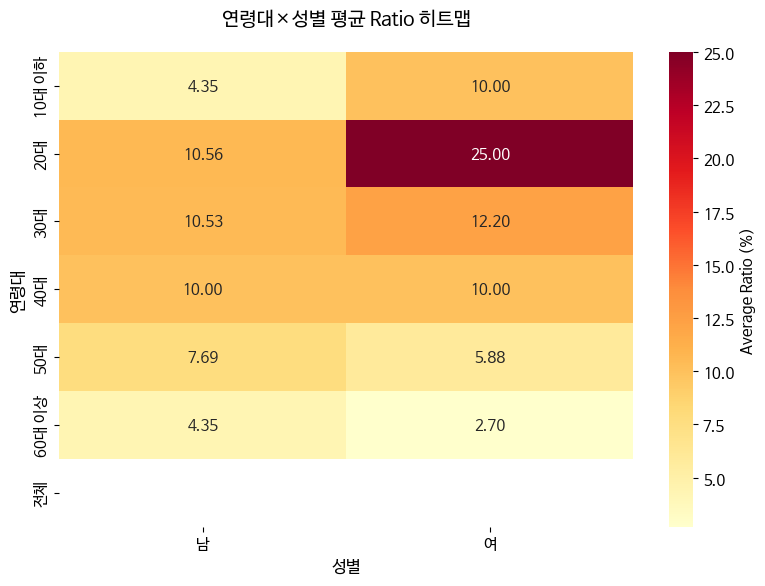

In [83]:
"""
median

"""
import matplotlib.pyplot as plt
import seaborn as sns

# 연령대×성별 평균 ratio 계산
heatmap_data = ver1_dataset.pivot_table(
      values='ratio',
      index='age_group_10',
      columns='gender',
      aggfunc='median'
  )

  # 연령대 순서 정렬
age_order = ['10대 이하', '20대', '30대', '40대', '50대', '60대 이상', '전체']
heatmap_data = heatmap_data.reindex(age_order)

  # 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd',
              cbar_kws={'label': 'Average Ratio (%)'})
plt.title('연령대×성별 평균 Ratio 히트맵', fontsize=14, pad=20)
plt.xlabel('성별', fontsize=12)
plt.ylabel('연령대', fontsize=12)
plt.tight_layout()
plt.show()


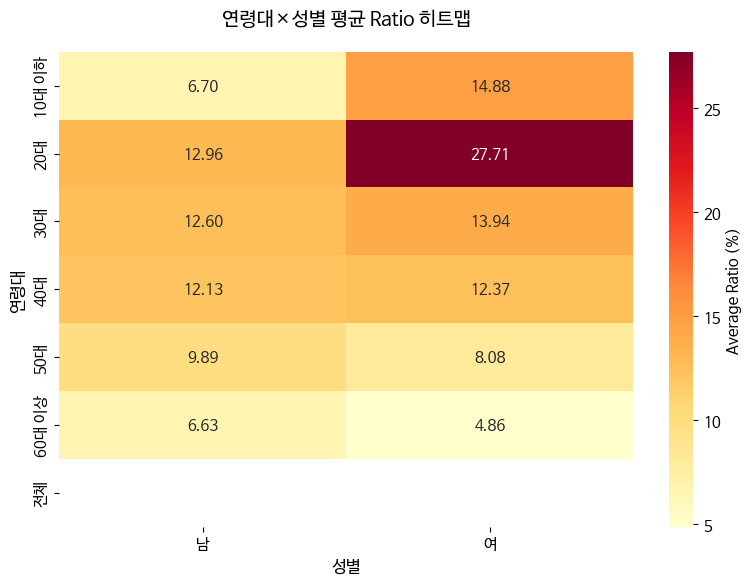

In [84]:
"""
mean

"""
import matplotlib.pyplot as plt
import seaborn as sns

# 연령대×성별 평균 ratio 계산
heatmap_data = ver1_dataset.pivot_table(
      values='ratio',
      index='age_group_10',
      columns='gender',
      aggfunc='mean'
  )

  # 연령대 순서 정렬
age_order = ['10대 이하', '20대', '30대', '40대', '50대', '60대 이상', '전체']
heatmap_data = heatmap_data.reindex(age_order)

  # 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd',
              cbar_kws={'label': 'Average Ratio (%)'})
plt.title('연령대×성별 평균 Ratio 히트맵', fontsize=14, pad=20)
plt.xlabel('성별', fontsize=12)
plt.ylabel('연령대', fontsize=12)
plt.tight_layout()
plt.show()


In [85]:
ver1_dataset.columns

Index(['period', 'age_group_10', 'gender', 'views', 'ratio', 'views_total',
       'category', 'title', 'tag', 'source_url', 'referrer', 'referrer_detail',
       'share', 'device', 'portal', 'is_search', 'is_community', 'is_edu',
       'is_mail', 'is_newsletter', 'is_blog', 'is_ai', 'is_sns'],
      dtype='object')

# [6] 데이터분석

## 6.1 referrer 대분류 X 연령대


[Referrer 대분류 × 연령대] 조회수 합계
age_group_10       10대 이하      20대      30대      40대     50대  60대 이상
referrer_category                                                   
AI검색엔진               2060     6797     3018     2585    1651     585
SNS                  1023     6747     4220     3051    1940     775
검색                 603000  1948253  1218129  1038474  607583  242761
교육기관                 1275     6782     3033     2654    1806     586
기타                  20257   179911   161030   113756   61288   22992
뉴스레터                  910     4891     2589     1865    1208     506
메일/그룹웨어              1396    15900    14286    10346    5891    2238
블로그                 83941   583349   349519   261768  153417   57596
커뮤니티                  262     2974     4946     1807     651     207
포털서비스                9749    65293    36994    27967   16640    5814

[비율] 각 유입 경로별 연령대 비중 (%)
age_group_10       10대 이하   20대   30대   40대   50대  60대 이상
referrer_category                                        
A

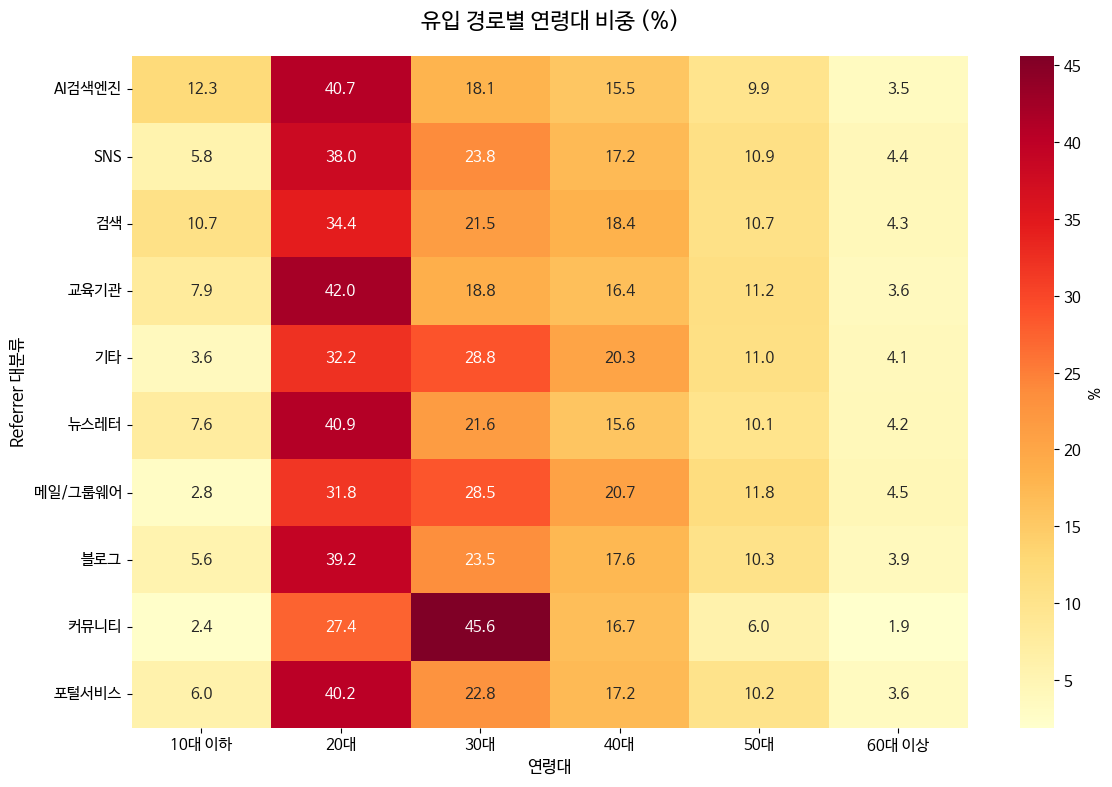


2. Referrer 대분류 × 카테고리


In [108]:
# 1-1. Referrer 대분류별 주요 연령대
ref_age = pd.crosstab(ver1_dataset['referrer_category'], ver1_dataset['age_group_10'],
                        values=ver1_dataset['views'], aggfunc='sum')
print("\n[Referrer 대분류 × 연령대] 조회수 합계")
print(ref_age)

  # 비율로 변환 (각 referrer별 100%)
ref_age_pct = ref_age.div(ref_age.sum(axis=1), axis=0) * 100
print("\n[비율] 각 유입 경로별 연령대 비중 (%)")
print(ref_age_pct.round(1))

  # 히트맵
plt.figure(figsize=(12, 8))
sns.heatmap(ref_age_pct, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': '%'})
plt.title('유입 경로별 연령대 비중 (%)', fontsize=16, pad=20)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('Referrer 대분류', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("2. Referrer 대분류 × 카테고리")
print("=" * 80)


##

## 6.2 카테고리별 유입 경로

/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12539 (\N{KATAKANA MIDDLE DOT}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


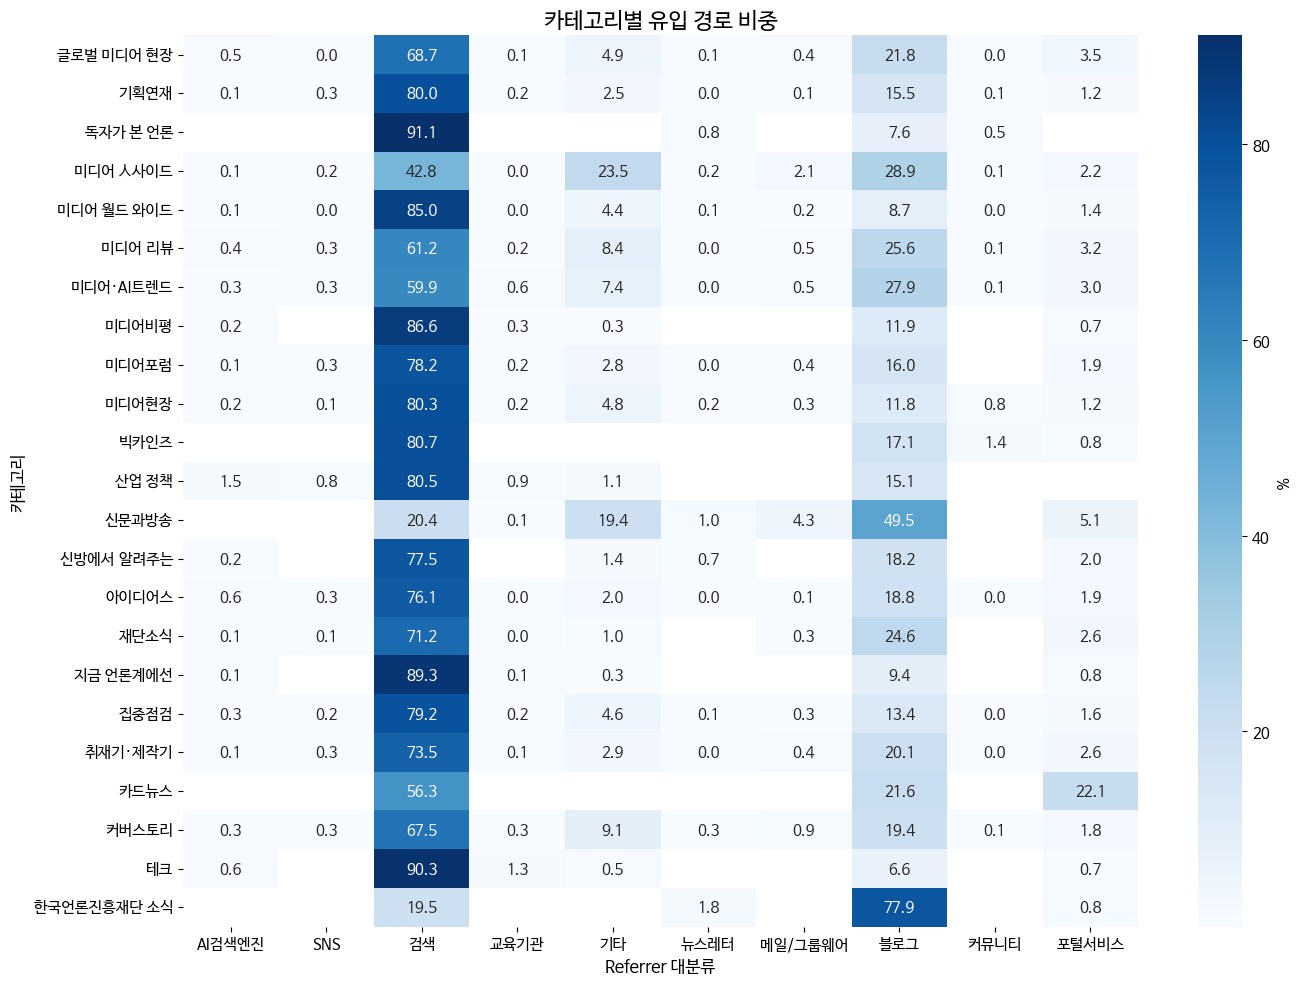

In [111]:
# 각 카테고리별로 어떤 유입 경로가 효과적인지
ref_cat = pd.crosstab(ver1_dataset['category'], ver1_dataset['referrer_category'],
                        values=ver1_dataset['views'], aggfunc='sum')
ref_cat_pct = ref_cat.div(ref_cat.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 10))
sns.heatmap(ref_cat_pct, annot=True, fmt='.1f', cmap='Blues', cbar_kws={'label': '%'})
plt.title('카테고리별 유입 경로 비중', fontsize=16)
plt.ylabel('카테고리', fontsize=12)
plt.xlabel('Referrer 대분류', fontsize=12)
plt.tight_layout()
plt.show()


## 6.3 디바이스 X referrer

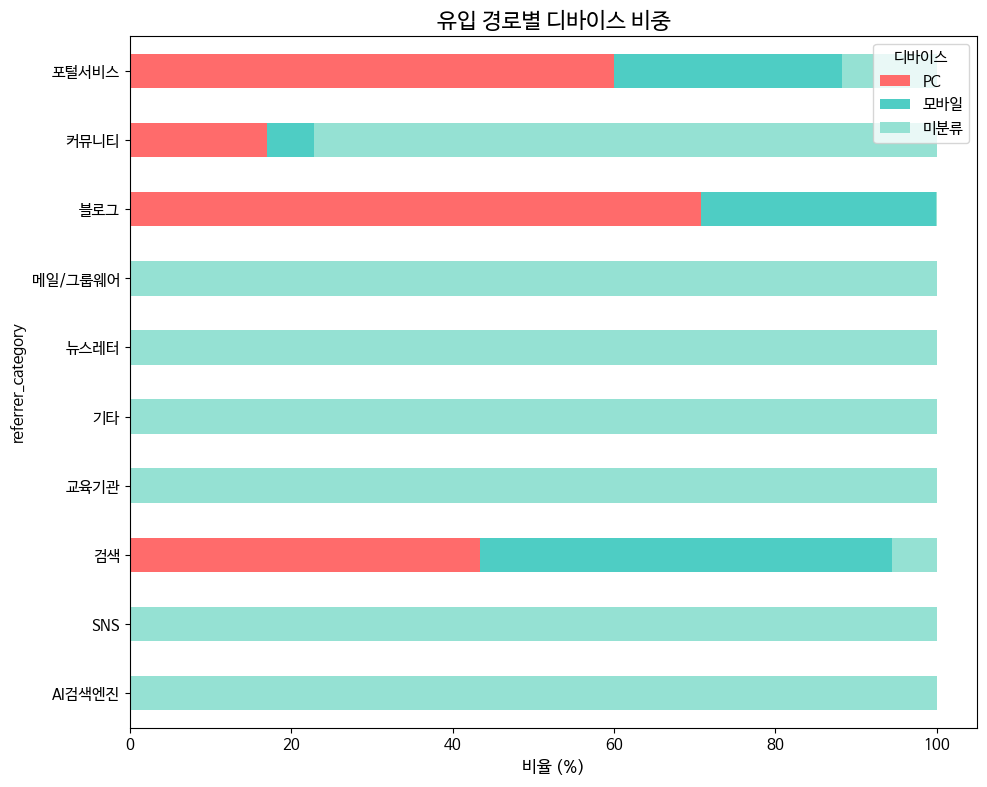

In [112]:

# 모바일 vs PC 비중
device_ref = pd.crosstab(ver1_dataset['referrer_category'], ver1_dataset['device'],
                           values=ver1_dataset['views'], aggfunc='sum')
device_ref_pct = device_ref.div(device_ref.sum(axis=1), axis=0) * 100

device_ref_pct.plot(kind='barh', stacked=True, figsize=(10, 8),
                       color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
plt.title('유입 경로별 디바이스 비중', fontsize=16)
plt.xlabel('비율 (%)', fontsize=12)
plt.legend(title='디바이스')
plt.tight_layout()


## 6.4 기간별 유입 경로 변화

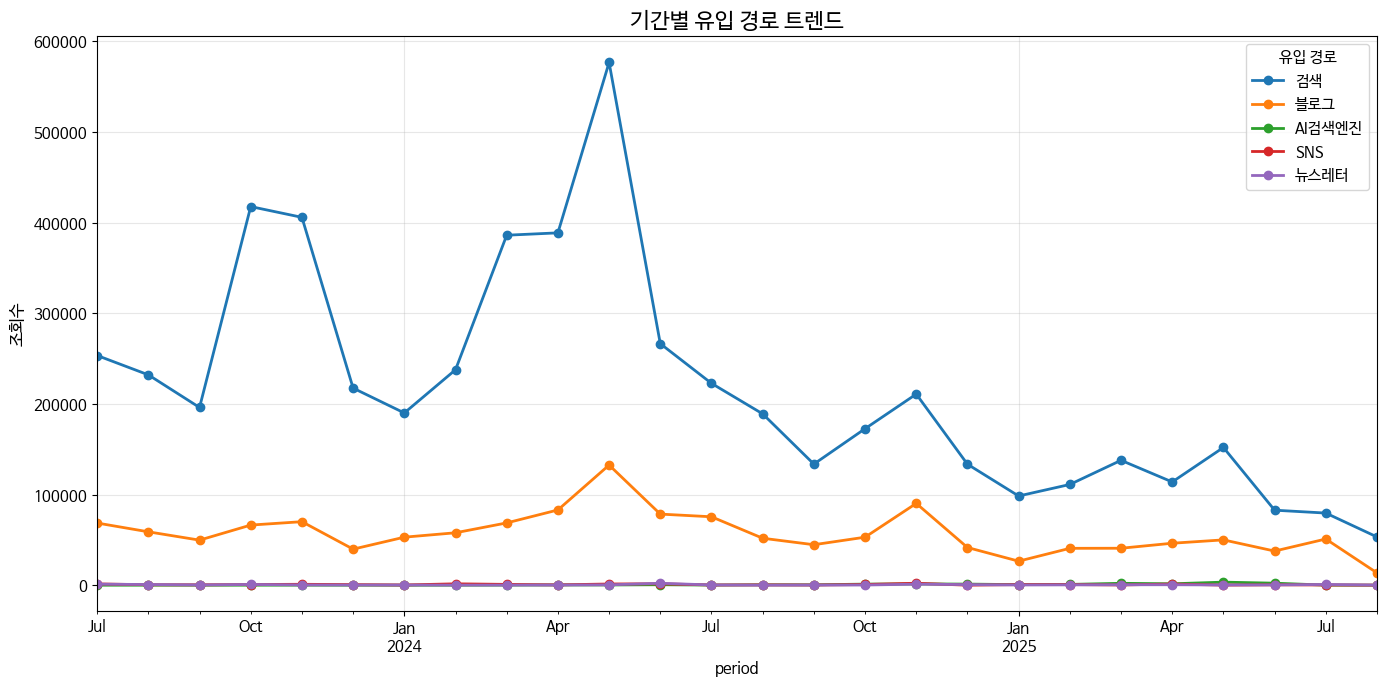

In [113]:
# 기간별 유입 경로 변화
ver1_dataset['period'] = pd.to_datetime(ver1_dataset['period'])
period_ref = ver1_dataset.groupby(['period', 'referrer_category'])['views'].sum().unstack(fill_value=0)

  # 상위 5개만
top_refs = ['검색', '블로그', 'AI검색엔진', 'SNS', '뉴스레터']
period_ref[top_refs].plot(figsize=(14, 7), marker='o', linewidth=2)
plt.title('기간별 유입 경로 트렌드', fontsize=16)
plt.ylabel('조회수', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='유입 경로')
plt.tight_layout()
plt.show()


## 6.5 유입경로별 조회수

1. Referrer 대분류별 조회수 분석
                      총_조회수  평균_조회수  중앙값_조회수      건수
referrer_category                                   
검색                 96287414  108.98     56.0  883535
블로그                25096642  124.15     87.0  202151
기타                 10607909  273.94    209.0   38724
포털서비스               2720381  142.91    115.0   19035
메일/그룹웨어              939832  195.35    142.0    4811
SNS                  331684  150.42    107.0    2205
AI검색엔진               282452   58.54     39.0    4825
교육기관                 269622   87.09     54.0    3096
뉴스레터                 210732  104.63     67.0    2014
커뮤니티                 194836  173.50     80.0    1123



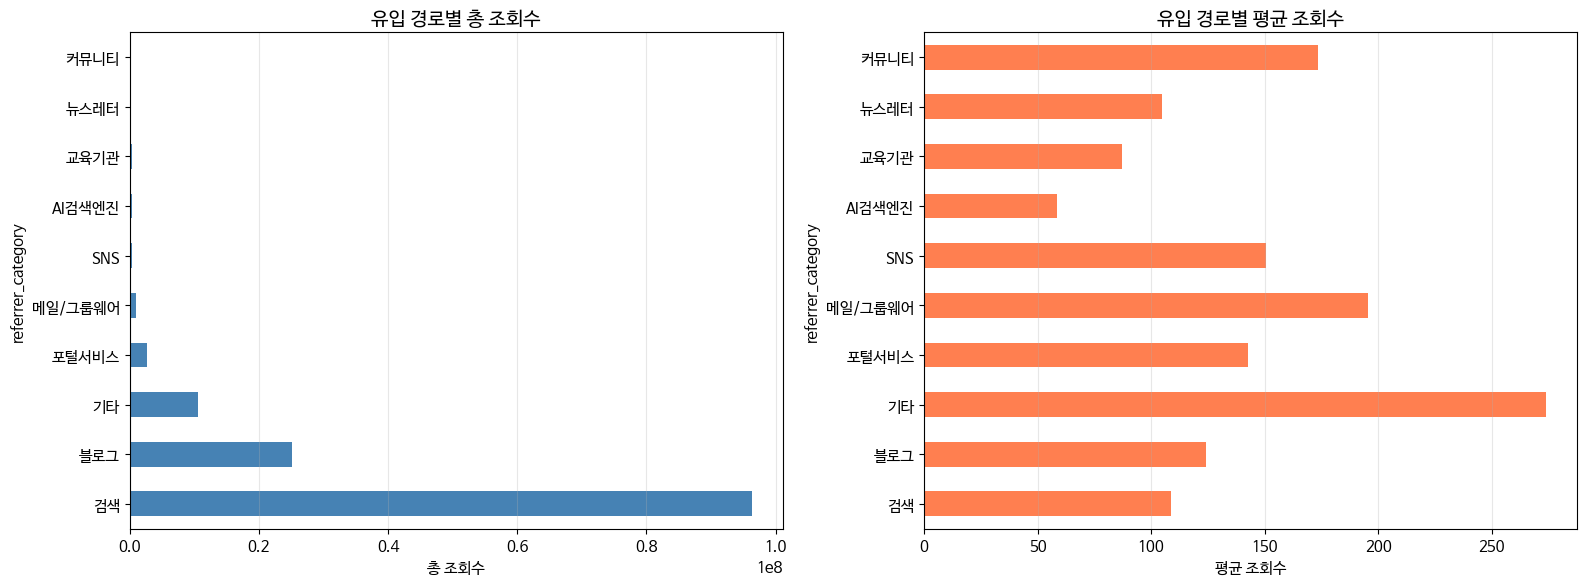

2. 카테고리별 조회수 TOP 10
               총_조회수  평균_조회수    레코드수
category                            
커버스토리       29650014  127.73  232123
집중점검        17222341  146.46  117594
미디어 월드 와이드  14178720  182.55   77670
미디어현장       14139188  107.13  131986
취재기·제작기     13693895   83.30  164384
미디어 人사이드    10090349  187.42   53837
미디어·AI트렌드    9265411  138.21   67040
미디어 리뷰       7743100  126.36   61279
미디어포럼        5441053   72.42   75136
기획연재         5268609   67.92   77576

3. 연령대 × 성별 조회수
                        총_조회수  평균_조회수
age_group_10 gender                  
10대 이하       남        6741341  140.01
             여       10476981  118.08
20대          남       12937737  112.27
             여       13518498   96.95
30대          남       12673421  113.56
             여       12951584  108.93
40대          남       12521039  114.17
             여       12836647  110.61
50대          남       12225214  121.43
             여       11911085  127.05
60대 이상       남       10381448  143.46
             여        776

In [116]:
print("=" * 80)
print("1. Referrer 대분류별 조회수 분석")
print("=" * 80)

ref_views = ver1_dataset.groupby('referrer_category').agg({
      'views_total': ['sum', 'mean', 'median'],
      'views': 'count'
  }).round(2)

ref_views.columns = ['총_조회수', '평균_조회수', '중앙값_조회수', '건수']
ref_views = ref_views.sort_values('총_조회수', ascending=False)
print(ref_views)
print()

  # 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ref_views['총_조회수'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('유입 경로별 총 조회수', fontsize=14)
axes[0].set_xlabel('총 조회수')
axes[0].grid(axis='x', alpha=0.3)

ref_views['평균_조회수'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('유입 경로별 평균 조회수', fontsize=14)
axes[1].set_xlabel('평균 조회수')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 80)
print("2. 카테고리별 조회수 TOP 10")
print("=" * 80)

cat_views = ver1_dataset.groupby('category').agg({
      'views_total': ['sum', 'mean'],
      'views': 'count'
  }).round(2)

cat_views.columns = ['총_조회수', '평균_조회수', '레코드수']
cat_views = cat_views.sort_values('총_조회수', ascending=False).head(10)
print(cat_views)
print()

print("=" * 80)
print("3. 연령대 × 성별 조회수")
print("=" * 80)

age_gender_views = ver1_dataset.groupby(['age_group_10', 'gender']).agg({
      'views_total': ['sum', 'mean']
  }).round(2)

age_gender_views.columns = ['총_조회수', '평균_조회수']
print(age_gender_views)
print()

print("=" * 80)
print("4. 디바이스별 조회수")
print("=" * 80)

device_views = ver1_dataset.groupby('device').agg({
      'views_total': ['sum', 'mean', 'median'],
      'views': 'count'
  }).round(2)

device_views.columns = ['총_조회수', '평균_조회수', '중앙값_조회수', '건수']
print(device_views)
print()

print("=" * 80)
print("5. 고조회 기사 특성 (상위 20%)")
print("=" * 80)

high_threshold = ver1_dataset['views_total'].quantile(0.8)
high_views = ver1_dataset[ver1_dataset['views_total'] >= high_threshold]

print(f"고조회 기준: {high_threshold:.0f} 이상")
print(f"고조회 기사: {len(high_views):,}건\n")

print("[고조회 기사 주요 유입 경로]")
high_ref = high_views['referrer_category'].value_counts(normalize=True).head(5) * 100
print(high_ref.round(1))
print()

print("[고조회 기사 주요 카테고리]")
high_cat = high_views['category'].value_counts(normalize=True).head(5) * 100
print(high_cat.round(1))
print()

print("[고조회 기사 주요 연령대]")
high_age = high_views['age_group_10'].value_counts(normalize=True) * 100
print(high_age.round(1))

print("\n분석 완료!")
